In [2]:
from __future__ import print_function
import torch
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn .functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.cuda import device_count
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Initialisation des constantes
batch_size = 128
num_classes = 10
epochs= 10
learning_rate = 0.001
encoding_dim = 32
noise_factor= 0.5
seuil = 0.5

In [4]:
# Chargement des données
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
mnist_train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
mnist_train_loader = torch.utils.data.DataLoader(mnist_train_set, batch_size=batch_size, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test_set, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 117749531.97it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 109131255.70it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43198941.85it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6892376.54it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
class Autoencoder(nn.Module): # Autoencoder
    def __init__(self): # Constructeur
        super(Autoencoder, self).__init__() # Heritage de la classe Module
        self.encoder = nn.Sequential( # Encodeur
            nn.Conv2d(1, 32, kernel_size=3, padding=1), # Convolutions 3x3 avec 32 filtres
            nn.ReLU(), # Fonction d'activation ReLU
            nn.MaxPool2d(2, 2), # Max pooling 2x2
            nn.Conv2d(32, 32, kernel_size=3, padding=1), # Convolutions 3x3 avec 32 filtres
            nn.ReLU(), # Fonction d'activation ReLU
            nn.MaxPool2d(2, 2) # Max pooling 2x2
        )
        self.decoder = nn.Sequential( # Decodeur
            nn.Conv2d(32, 32, kernel_size=3, padding=1), # Convolutions 3x3 avec 32 filtres
            nn.ReLU(), # Fonction d'activation ReLU
            nn.UpsamplingNearest2d(scale_factor=2), # Upsampling 2x2
            nn.Conv2d(32, 32, kernel_size=3, padding=1), # Convolutions 3x3 avec 32 filtres
            nn.ReLU(),  # Fonction d'activation ReLU
            nn.UpsamplingNearest2d(scale_factor=2), # Upsampling 2x2
            nn.Conv2d(32, 1, kernel_size=3, padding=1), # Convolutions 3x3 avec 1 filtre
            nn.Sigmoid() # Fonction d'activation Sigmoid
        )

    def forward(self, x): # Propagation avant
        x = self.encoder(x) # Encodeur
        x = self.decoder(x) # Decodeur
        return x # Retourne la sortie du decodeur

In [6]:
AE = Autoencoder() # Initialisation du reseau de neurones de l'autoencodeur

criterion = nn.BCELoss() # Fonction de cout (entropie croisee binaire)
optimizer = optim.Adam(AE.parameters(), lr=learning_rate) # Choix de l'optimiseur Adam

In [7]:
list_loss_train = [] # Liste de loss pour l'entrainement
list_accuracy_train = [] # Liste d'accuracy pour l'entrainement
list_loss_test = [] # Liste de loss pour le test
list_accuracy_test = [] # Liste d'accuracy pour le test
seuil = 0.5 # Seuil pour la binarisation

for epoch in range(epochs): # On parcourt les epochs
    AE.train() # Mode entrainement
    sous_list_loss_train = [] # Liste de loss pour l'entrainement
    sous_valeur_accuracy_train = 0 # Valeur d'accuracy pour l'entrainement
    for data in mnist_train_loader: # On parcourt les donnees d'entrainement
        img, _ = data # On recupere l'image
        img = torch.clamp(img, 0., 1.) # On borne l'image entre 0 et 1
        noisy_img = img + torch.randn(img.size()) * noise_factor # On ajoute du bruit a l'image
        noisy_img = torch.clamp(noisy_img, 0., 1.) # On borne l'image entre 0 et 1
        optimizer.zero_grad() # On met a zero les gradients
        output = AE(noisy_img) # On calcule la sortie du reseau
        loss = criterion(output, img) # On calcule la loss
        loss.backward() # On calcule les gradients
        optimizer.step() # On met a jour les poids

        sous_list_loss_train.append(loss.item()) # On ajoute la loss a la liste
        sous_valeur_accuracy_train += ((output > seuil) == (img > seuil)).sum().item() # On ajoute l'accuracy a la valeur

    total_pixels = img.view(img.size(0), -1).size(1) # Nombre de pixels dans l'image
    list_accuracy_train.append(sous_valeur_accuracy_train / (len(mnist_train_set) * total_pixels)) # On ajoute l'accuracy a la liste
    list_loss_train.append(np.mean(sous_list_loss_train)) # On ajoute la loss a la liste

    AE.eval() # Mode evaluation
    with torch.no_grad(): # Pas de calcul de gradient
        sous_list_loss_test = [] # Liste de loss pour le test
        sous_valeur_accuracy_test = 0 # Valeur d'accuracy pour le test
        for data in mnist_test_loader: # On parcourt les donnees de test
            img, _ = data # On recupere l'image
            img = torch.clamp(img, 0., 1.) # On borne l'image entre 0 et 1
            noisy_img = img + torch.randn(img.size()) * noise_factor # On ajoute du bruit a l'image
            noisy_img = torch.clamp(noisy_img, 0., 1.) # On borne l'image entre 0 et 1
            output = AE(img) # On calcule la sortie du reseau
            loss = criterion(output, img) # On calcule la loss
            sous_list_loss_test.append(loss.item()) # On ajoute la loss a la liste
            sous_valeur_accuracy_test += ((output > seuil) == (img > seuil)).sum().item() # On ajoute l'accuracy a la valeur

        total_pixels = img.view(img.size(0), -1).size(1) # Nombre de pixels dans l'image
        list_accuracy_test.append(sous_valeur_accuracy_test / (len(mnist_test_set) * total_pixels)) # On ajoute l'accuracy a la liste
        list_loss_test.append(np.mean(sous_list_loss_test)) # On ajoute la loss a la liste


    print('epoch [{}/{}], loss train:{:.4f}, loss test:{:.4f}, accuracy train:{:.4f}, accuracy test:{:.4f}'.format(epoch + 1, epochs, list_loss_train[-1], list_loss_test[-1], list_accuracy_train[-1], list_accuracy_test[-1]))

epoch [1/10], loss train:0.1588, loss test:0.0720, accuracy train:0.9335, accuracy test:0.9720
epoch [2/10], loss train:0.0902, loss test:0.0575, accuracy train:0.9637, accuracy test:0.9794
epoch [3/10], loss train:0.0825, loss test:0.0525, accuracy train:0.9673, accuracy test:0.9815
epoch [4/10], loss train:0.0784, loss test:0.0512, accuracy train:0.9692, accuracy test:0.9816
epoch [5/10], loss train:0.0757, loss test:0.0475, accuracy train:0.9705, accuracy test:0.9836
epoch [6/10], loss train:0.0738, loss test:0.0458, accuracy train:0.9713, accuracy test:0.9846
epoch [7/10], loss train:0.0725, loss test:0.0446, accuracy train:0.9719, accuracy test:0.9851
epoch [8/10], loss train:0.0712, loss test:0.0442, accuracy train:0.9725, accuracy test:0.9850
epoch [9/10], loss train:0.0704, loss test:0.0430, accuracy train:0.9728, accuracy test:0.9857
epoch [10/10], loss train:0.0695, loss test:0.0422, accuracy train:0.9733, accuracy test:0.9861


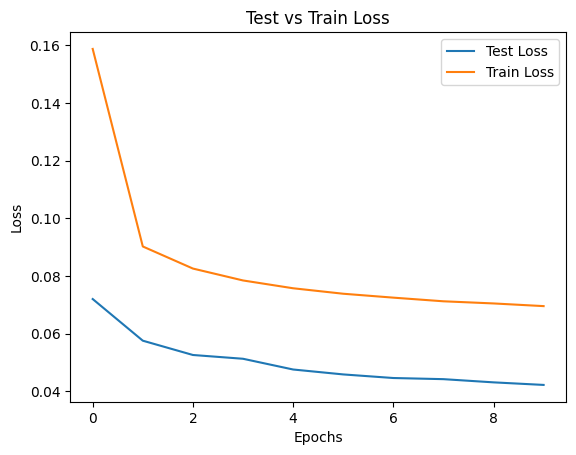

In [8]:
# Affichage des courbes de la loss pour le train et le test
plt.plot(list_loss_test, label='Test Loss')
plt.plot(list_loss_train, label='Train Loss')

plt.title('Test vs Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

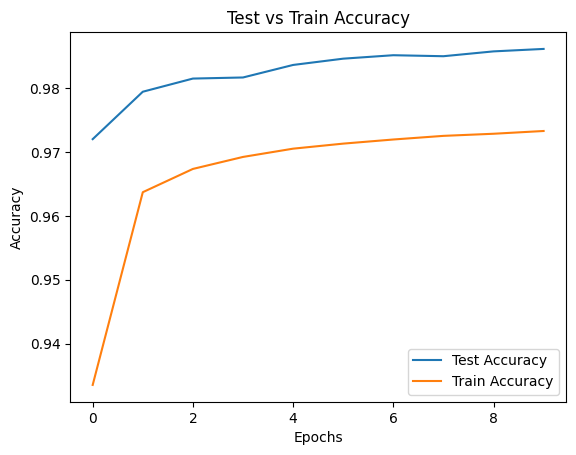

In [9]:
# Affichage des courbes de l'accuracy pour le train et le test

plt.plot(list_accuracy_test, label='Test Accuracy')
plt.plot(list_accuracy_train, label='Train Accuracy')

plt.title('Test vs Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

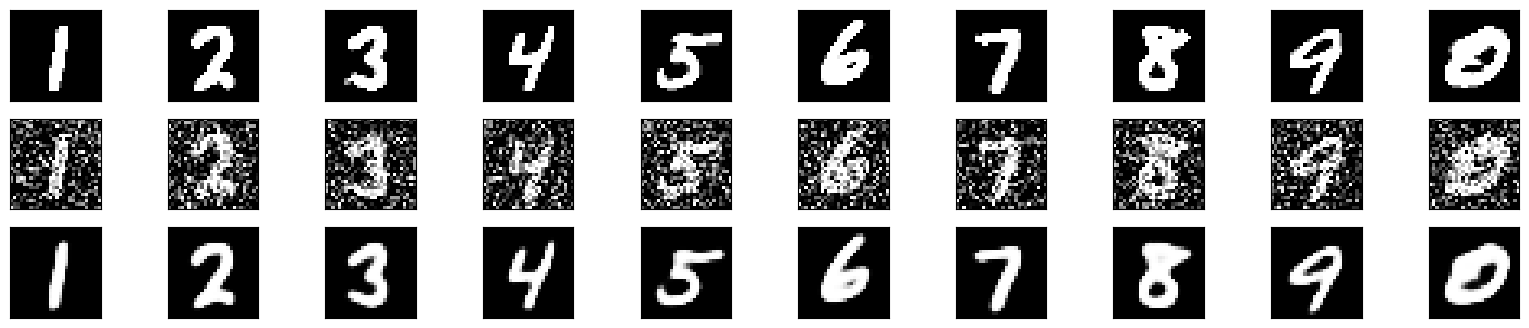

In [ ]:
# Affichage des chiffres avant encodage, bruité et après décodage
n = 10

plt.figure(figsize=(20, 4))

for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(img[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_img[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + n * 2)
    plt.imshow(output[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()